In [1]:
# set root dir in system path
import sys
sys.path.insert(0, '/Users/dish/Code/codeQual')
print(sys.path)
from codeQual import set_device
device = set_device.set()

['/Users/dish/Code/codeQual', '/Users/dish/Code/codeQual/notebooks', '/Users/dish/anaconda3/envs/codequal/lib/python310.zip', '/Users/dish/anaconda3/envs/codequal/lib/python3.10', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/lib-dynload', '', '/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages']


In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = '/Users/dish/Code/codeQual/training_output/checkpoint-232'
num_classes = 3
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes, max_length=512).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

In [3]:
from transformers import AutoTokenizer
from datasets import Dataset, DatasetDict, load_dataset
code_qual_dataset = DatasetDict.load_from_disk('../data/CodeQualData/code_qual_dataset')

def tokenize(batch):
    return tokenizer(batch["submission"], padding=True, truncation=True)


codequal_encoded: DatasetDict = code_qual_dataset.map(tokenize, batched=True, batch_size=None)
codequal_encoded

Map: 100%|██████████| 145/145 [00:00<00:00, 7338.89 examples/s]


DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 461
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 116
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 145
    })
})

In [4]:
from torch.nn.functional import cross_entropy
import torch

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [5]:
# Convert our dataset back to PyTorch tensors

codequal_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
# Compute loss values
codequal_encoded["validation"] = codequal_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)
codequal_encoded

Map: 100%|██████████| 116/116 [00:02<00:00, 46.15 examples/s]


DatasetDict({
    train: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 461
    })
    validation: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
        num_rows: 116
    })
    test: Dataset({
        features: ['problem_id', 'problem', 'submission_id', 'submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 145
    })
})

In [14]:
codequal_encoded.set_format("pandas")
cols = ["problem", "submission", "label", "predicted_label", "loss"]
df_valid = codequal_encoded["validation"][:][cols]
df_valid

,problem,submission,label,predicted_label,loss
0,The code takes a string as input and appends '...,# -*- coding: utf-8 -*-\n\ndef answer(s):\n ...,2,1,1.146564
1,Snuke has a calculator. It has a display and t...,"x, y = map(int, input().split())\ndif = abs(ab...",1,1,0.212066
2,The code computes the minimum number of times ...,"n = int(input())\na = list(map(int, input().sp...",0,0,0.237920
3,This code takes a word as input and then check...,word = input()\nif word.endswith('s'):\n prin...,1,1,0.584925
4,The code reads an integer (n) and then reads n...,"n=int(input())\ns=list(map(int,input().split()...",1,0,1.759817
...,...,...,...,...,...
111,You are taking a computer-based examination. T...,N = int(input())\nS = [int(input()) for _ in r...,1,1,0.211377
112,The code takes an integer input denoting the n...,"n=int(input())\na=list(map(int,input().split()...",1,1,0.699269
113,"Code reads a word, checks if it ends with 's',...",word = input()\nif (word.endswith('s')):\n ...,1,1,0.579420
114,You will be given a string S of length 3 repre...,line = input()\nline2 = input()\ncount = 0\nif...,1,1,0.401516


In [15]:
df_valid.sort_values("loss", ascending=False).head(10)

,problem,submission,label,predicted_label,loss
83,There are N integers written on a blackboard. ...,def main():\n import sys\n input = sys.s...,2,1,3.627894
93,You are given two integers A and B.\nPrint a g...,"a, b = map(int, input().split())\n\na -= 1\nb ...",2,1,2.916127
15,Takahashi will do a tap dance. The dance is de...,import sys\n\nread = sys.stdin.read\nreadline ...,2,1,2.797327
115,You are given two integers A and B as the inpu...,import sys\nimport itertools\nsys.setrecursion...,2,1,2.163872
95,Dolphin resides in two-dimensional Cartesian p...,import sys\ninput = sys.stdin.readline\nsys.se...,2,1,2.055897
47,The code takes an integer input 'N' representi...,"N =int(input())\nList = list(map(int, input()....",1,0,1.998440
97,We have N dice arranged in a line from left to...,import sys\n\n\n# \n\ndef input():\n return...,0,1,1.963489
61,This code reads an integer 'n' from input repr...,from sys import stdin\nn = stdin.readline().rs...,1,0,1.963151
46,The code takes an integer 'n' as input followe...,"n = int(input())\na = list(map(int, input().sp...",1,0,1.857147
98,"Given a list of integers, this code repeatedly...","n = int(input())\na = list(map(int, input().sp...",1,0,1.842110


In [8]:
df_valid.sort_values("loss", ascending=True).head(10)

,submission,label,predicted_label,loss
19,"# 28\nN = int(input())\nAn = list(map(int, inp...",0,0,0.140794
76,import sys\nn = int(input())\na = list(map(int...,0,0,0.144307
42,digit = int(input())\nli = list(input().split(...,0,0,0.151260
94,"N = int(input())\nA = list(map(int, input().sp...",0,0,0.152772
68,n = int(input())\nnum = [int(x) for x in input...,0,0,0.153069
99,"n = int(input())\na = list(map(int, input().sp...",0,0,0.154628
53,"\nn = int(input())\nx = list(map(int,input().s...",0,0,0.156221
24,"import sys\n\nread=sys.stdin.read\nn, *a=map(i...",0,0,0.158462
39,"N = int(input())\nls = list(map(int,input().sp...",0,0,0.158665
9,"n=int(input())\nn_list=list(map(int,input().sp...",0,0,0.164693


In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return accuracy, f1, precision, recall

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [11]:
import numpy as np

Y_valid = np.array(df_valid["label"])
Y_valid_preds = np.array(df_valid["predicted_label"])
Y_valid.shape, Y_valid_preds.shape

((116,), (116,))

In [12]:
print(evaluate(Y_valid, Y_valid_preds))

(0.6551724137931034, 0.6088246199480905, 0.5705404509283819, 0.6551724137931034)


/Users/dish/anaconda3/envs/codequal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


['low', 'average', 'high']


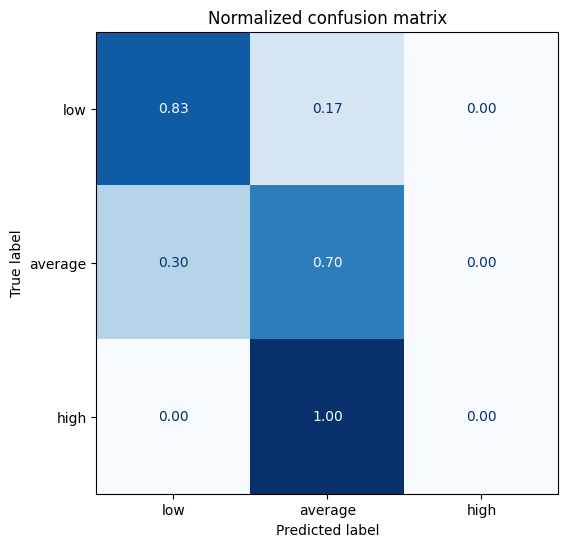

In [13]:
labels = code_qual_dataset['train'].features["label"].names
print(labels)
plot_confusion_matrix(Y_valid_preds, Y_valid, labels)